# <a name="0.0"></a>Содержание:
* [Описание проекта](#0.)
    - [Описание данных](#0.1.)
* [Шаг 1. Открываем файл и изучаем общую информацию](#1.)
    - [Вывод](#1.1.)
* [Шаг 2. Разделяем исходные данные на обучающую, тестовую и валидационную выборки](#2.)
    - [Вывод](#2.1.)
* [Шаг 3. Обучение без учёта дизбаланса классов](#3.)
    - [Вывод](#3.1.)
* [Шаг 4. Обучение с учётом дизбаланса классов](#4.)
    - [Балансировка классов с помощью изменения весов](#4.1.)
    - [Балансировка классов с помощью увеличения выборки (upsampling)](#4.2.)
    - [Балансировка классов с помощью уменьшения выборки (downsampling)](#4.3.)
    - [Оценка лучшей модели](#4.4.)
    - [Вывод](#4.5.)
* [Шаг 5. Финальное тестирование](#5.)
* [Шаг 6. Общие выводы](#6.)

<a name="0."></a>
## Описание проекта
Из банка уходят клиенты. Необходимо спрогнозировать, уйдёт ли клиент из банка в ближайшее время или нет. Исходный массив данный представляет исторические данные о поведедении клиентов и расторжении договоров с банком.
Необходимо построить модель с предельно большим значением f1-метрики (минимум 0.59). Дополнительно необходимо измерять AUC-ROC.
<br>
<font size="2">([к содержанию](#0.0))</font>

<a name="0.1."></a>
### Описание данных:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="1."></a>
# Шаг 1. Открываем файл и изучаем общую информацию
<font size="2">([к содержанию](#0.0))</font>

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import math

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

In [2]:
data = pd.read_csv('./datasets/Churn.csv', index_col=0)

In [3]:
data.tail()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
Exited,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [6]:
unique_name=data.Surname.unique()
print('Уникальных имён:', len(unique_name))
data.Surname.value_counts()

Уникальных имён: 2932


Smith         32
Martin        29
Scott         29
Walker        28
Brown         26
              ..
Mosley         1
Tilley         1
Liardet        1
Steen          1
Kuykendall     1
Name: Surname, Length: 2932, dtype: int64

In [7]:
len(data.CustomerId.unique())

10000

In [8]:
data.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [9]:
data.Gender.unique()

array(['Female', 'Male'], dtype=object)

[]

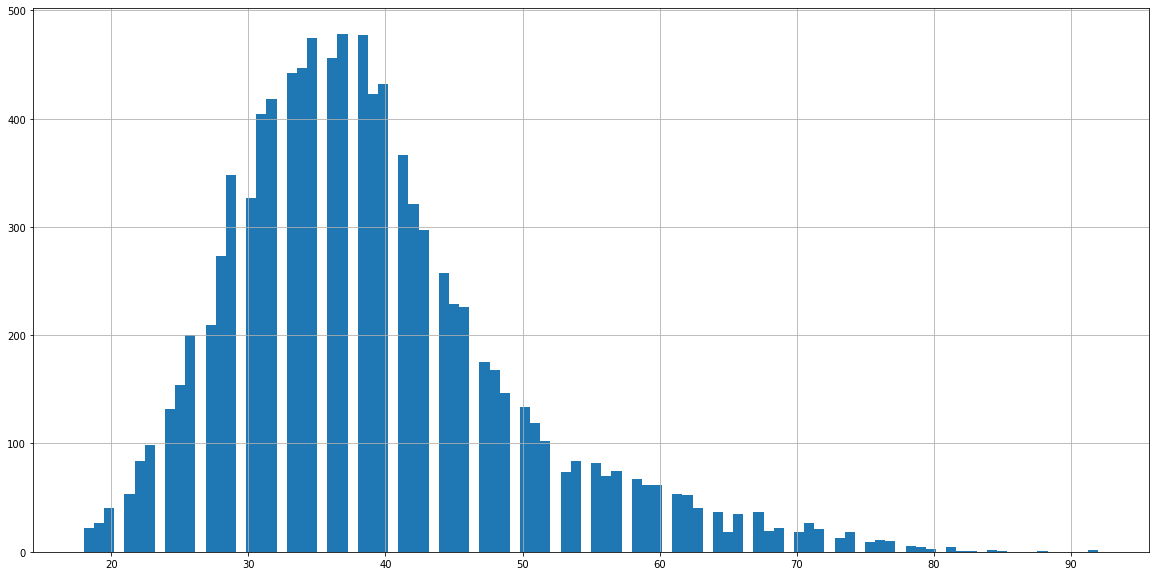

In [10]:
data.Age.hist(bins=100, figsize=(20,10))
plt.plot()

In [11]:
# Клиенты, которые не указали недвижимость
data[data.Tenure.isnull()]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0


In [12]:
data.Tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

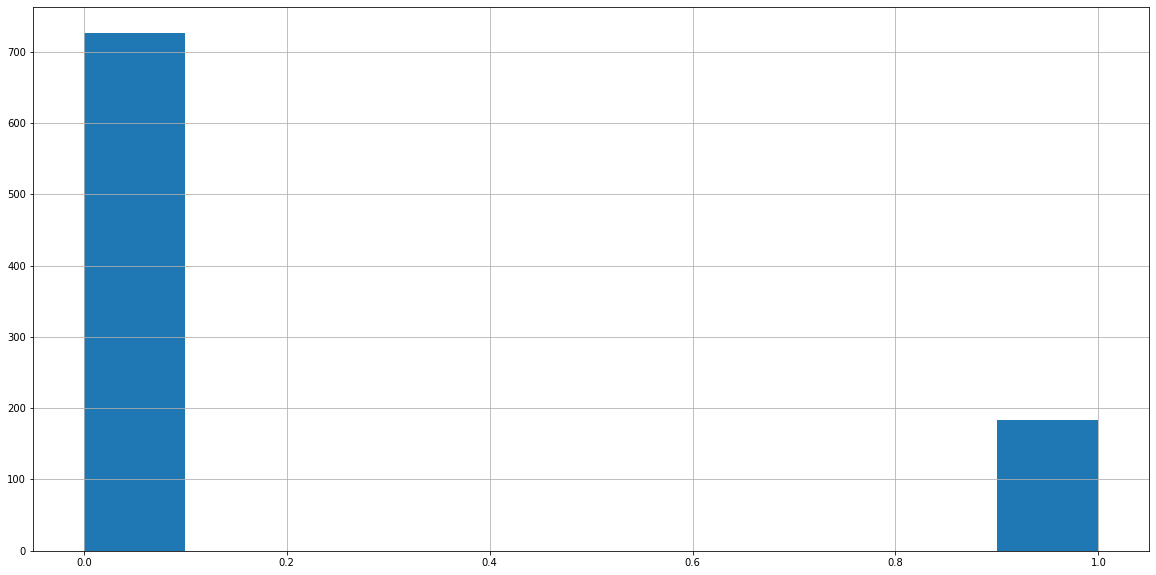

In [13]:
data[data.Tenure.isnull()].Exited.hist(figsize=(20,10))
plt.show()

In [14]:
data.NumOfProducts.value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [15]:
data.HasCrCard.value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [16]:
data.IsActiveMember.value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

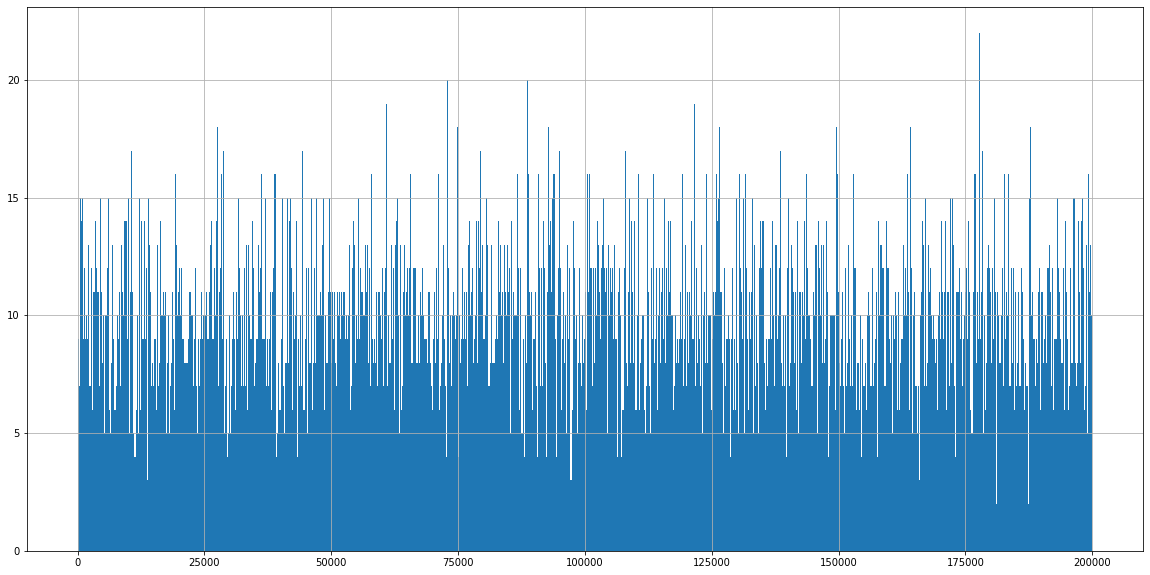

In [17]:
data.EstimatedSalary.hist(bins=1000, figsize=(20,10))
plt.show()

In [18]:
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [19]:
# Выбрасываем строки с пустими ячейками о количестве недвижимости
data.dropna(inplace=True, axis=0)
# Преобразуем столбец с количеством недвижимости к целым числам
data.Tenure=data.Tenure.astype('int64')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 1 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       9091 non-null   int64  
 1   Surname          9091 non-null   object 
 2   CreditScore      9091 non-null   int64  
 3   Geography        9091 non-null   object 
 4   Gender           9091 non-null   object 
 5   Age              9091 non-null   int64  
 6   Tenure           9091 non-null   int64  
 7   Balance          9091 non-null   float64
 8   NumOfProducts    9091 non-null   int64  
 9   HasCrCard        9091 non-null   int64  
 10  IsActiveMember   9091 non-null   int64  
 11  EstimatedSalary  9091 non-null   float64
 12  Exited           9091 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 994.3+ KB


In [21]:
#Удаляем столбец с фамилией
data = data.drop(['Surname'], axis=1, errors='ignore')

In [22]:
data = pd.get_dummies(data, drop_first=True)

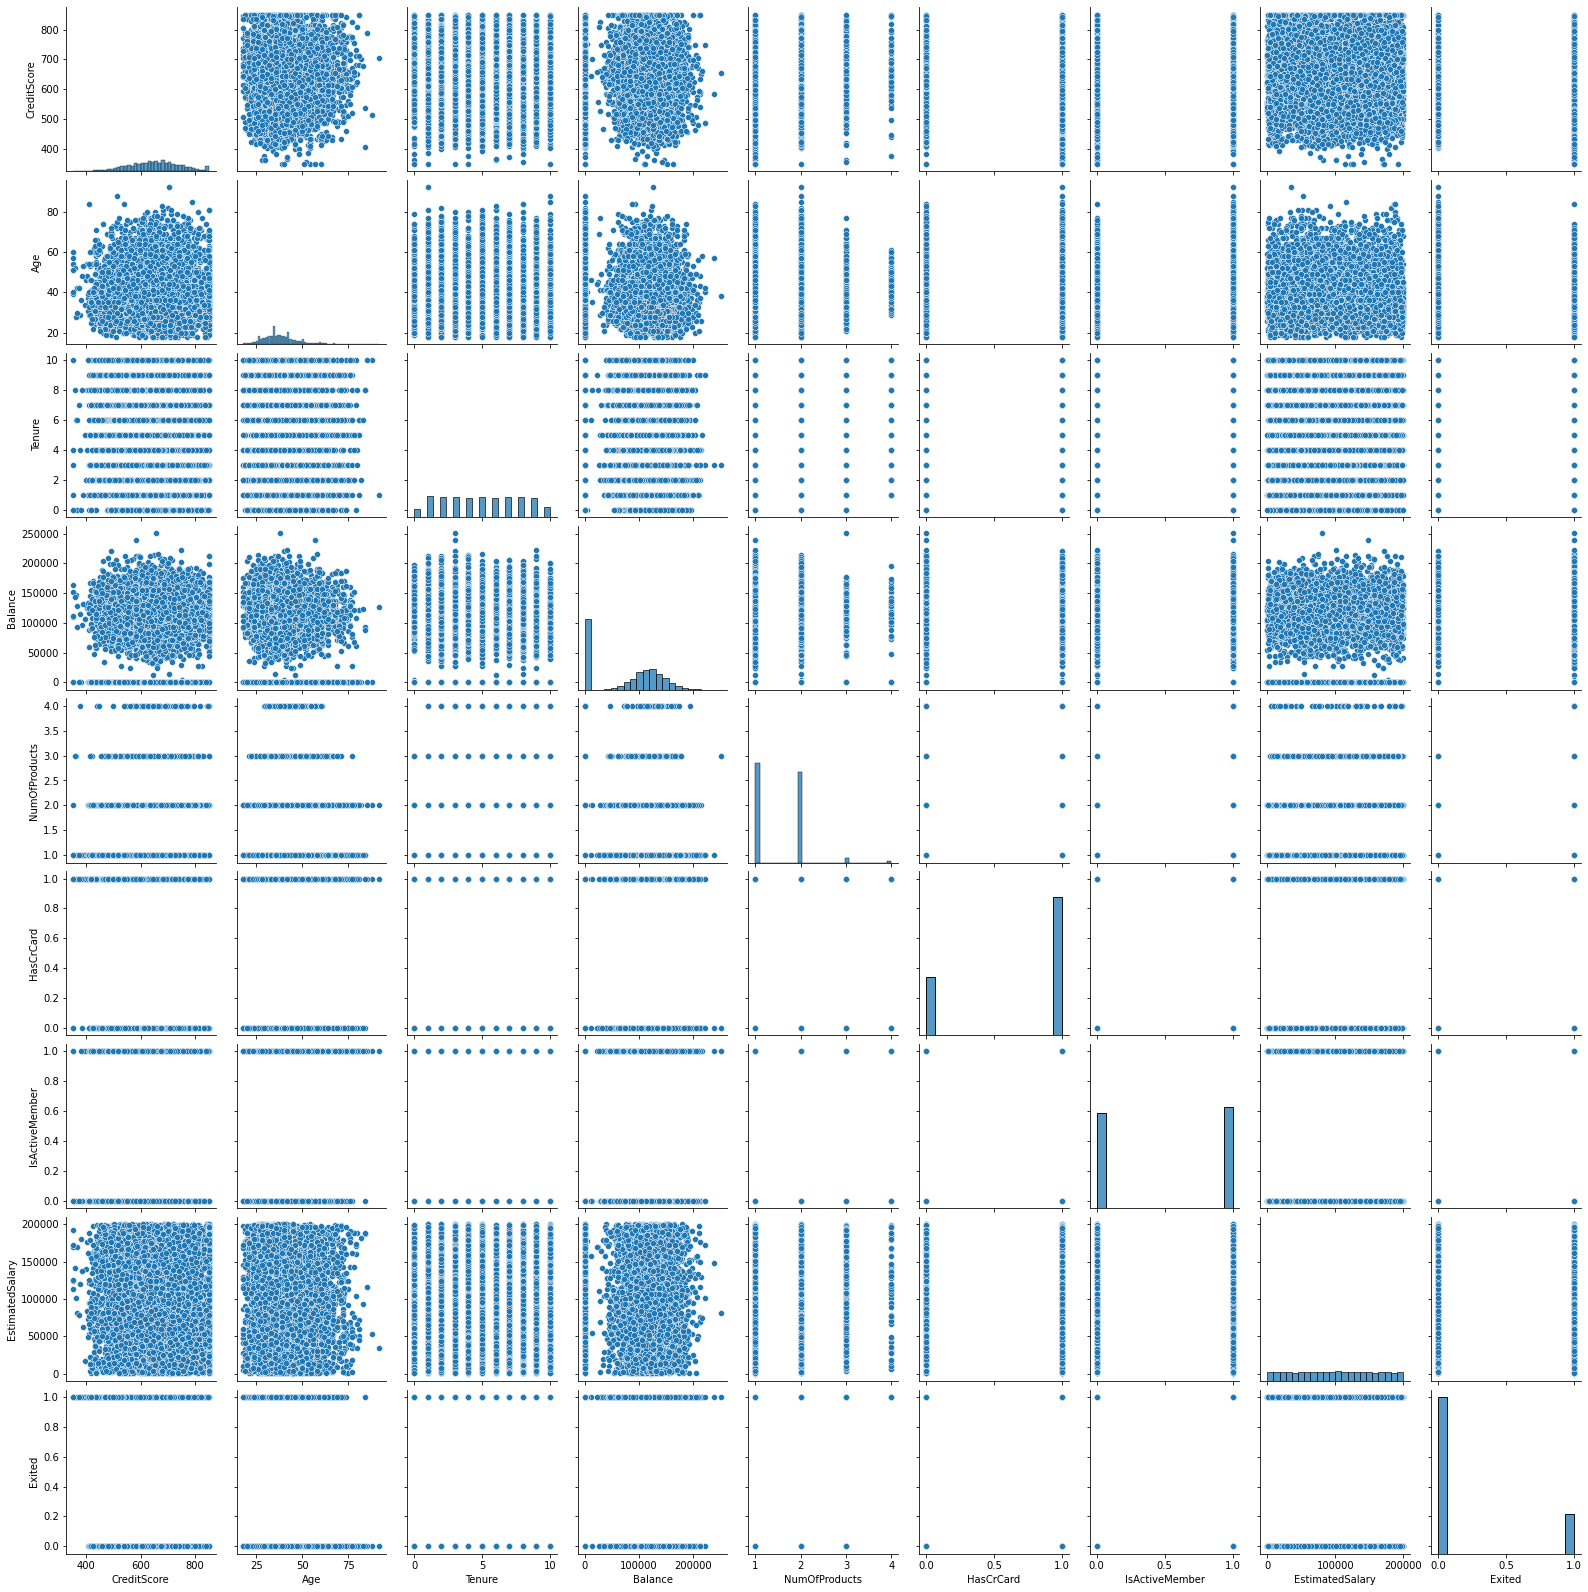

In [23]:
sns.pairplot(data.drop(['CustomerId', 
                        'Geography_Germany',
                        'Geography_Spain',
                        'Gender_Male'], axis=1))
plt.show()

<a name="1.1."></a>
## Вывод

Исходный dataset представляет собой таблицу размера 10_000 на 12. В качестве индексов используется первый столбец csv-Файла, соответствующий уникальному индексу строки в БД. В базе данных существует 2932 уникальных фамилии, что позволяет сделать предположении о возможности выделения наиболее частых фамилий в отдельный признак, однако для построения простых алгоритмов машинного обучения было решено его отбросить. В данных  присутствует информация о клиентах только из 3 стран: Франции, Германии и Испании. Распределение целевого признака, а именно факта ухода клиента, имеет вид распредлеения Бернули с преобладанием клиентов, которые до сих пор пользуются услугами банка (4:1). По 909 клиентам нет информации о количестве недвижимости у них, и так как распределение в них целевого признака такое же, как и в генеральной совокупности, их можно выбросить. Для кодирования признаков Geography и Gender используется One Hot Encoding с избеганием дамми-ловушки. Между данными не наблюдается взаимной корреляции, следовательно, исключать признаки нет необходимости. Большинсто непрерывных данных имеют вид нормального распределения, смещённых вправо или влево. Признак, отвечающий за количество недвижимости у клиентов, имеет нормальное распределение. Судя по распредению признака о наличие кредитной карты, пользователи данного банка часто пользуются этой услугой <br>
<font size="2">([к содержанию](#0.0))</font>

<a name="2."></a>
# Шаг 2. Разделяем исходные данные на обучающую, тестовую и валидационную выборки

<font size="2">([к содержанию](#0.0))</font>

In [24]:
# Выделим три набора обучающий, валидационный и тестовый в соотношение 60%:20%:20%
train, test_valid = train_test_split(data, train_size=0.6, random_state=123)
test, valid = train_test_split(test_valid, train_size=0.5, random_state=123)

In [25]:
# Выделяем признаки и целевую функцию
train_features = train.drop(['Exited'],axis=1)
test_features = test.drop(['Exited'],axis=1)
valid_features = valid.drop(['Exited'],axis=1)

train_target = train['Exited']
test_target = test['Exited']
valid_target = valid['Exited']

In [26]:
# Нормируем значения
scaler = StandardScaler()
scaler.fit(train_features)

train_features_normalized = scaler.transform(train_features)
test_features_normalized = scaler.transform(test_features)
valid_features_normalized = scaler.transform(valid_features)

<a name="2.1."></a>
## Вывод

Деление данных осуществляется на 3 группы: обучающая, валидационная и тестовая в соотношении 3:1:1 (60%:20%:20%). Так как у всех признаков различный масштаб, нормируем данные с помощью вычитания среднего и деления на среднеквадратичное отклонение.<br>
<font size="2">([к содержанию](#0.0))</font>

<a name="3."></a>
# Шаг 3. Обучение без учёта дизбаланса классов

<font size="2">([к содержанию](#0.0))</font>

In [27]:
def estimate_f1(y_test, y_pred):
    return f1_score(y_test, y_pred, labels=np.unique(y_pred))

In [28]:
# Строим стационарную модель
train_pred_constant = pd.Series(0, index=train.index)
valid_pred_constant = pd.Series(0, index=valid.index)

In [29]:
# Data frame для хранения результатов
statistics_temp_1 = pd.DataFrame({'model': ['Статическая модель'],
                                  'isBalansed': [None]
                                 })
data_statistics_train = pd.DataFrame(
    {'accuracy': [accuracy_score(train_target, train_pred_constant)],
     'recall': [recall_score(train_target, train_pred_constant)],
     'precision': [precision_score(train_target, train_pred_constant)],
     'f1': [estimate_f1(train_target, train_pred_constant, )],
     'auc_roc': [0.5]})

data_statistics_valid = pd.DataFrame(
    {'accuracy': [accuracy_score(valid_target, valid_pred_constant)],
     'recall': [recall_score(valid_target, valid_pred_constant)], 
     'precision': [precision_score(valid_target, valid_pred_constant)],
     'f1': [estimate_f1(valid_target, valid_pred_constant)],
     'auc_roc':[0.5]})
                                   
#Объединяем DataFrame
statistics = pd.merge(
    pd.merge(
        statistics_temp_1, data_statistics_train,
        left_index=True, right_index=True),
    data_statistics_valid, 
    left_index=True, right_index=True,
    suffixes=['_train', '_valid'])
statistics

C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,isBalansed,accuracy_train,recall_train,precision_train,f1_train,auc_roc_train,accuracy_valid,recall_valid,precision_valid,f1_valid,auc_roc_valid
0,Статическая модель,None,0.796296,0.0,0.0,0.0,0.5,0.783397,0.0,0.0,0.0,0.5


In [30]:
def solved_metrics(model, balansed,
                   model_name, train_features,
                   train_target, valid_features,
                   valid_target, print_info=False
                  ):
    global statistics
    # Метрики на обучающем наборе
    predicted_train = model.predict(train_features)
    probabilities_train = model.predict_proba(train_features)
    probabilities_one_train = probabilities_train[:, 1]
    
    accuracy_train = accuracy_score(train_target, predicted_train)
    precision_train = precision_score(train_target, predicted_train)
    recall_train = recall_score(train_target, predicted_train)
    f1_train = estimate_f1(train_target, predicted_train)
    roc_auc_train = roc_auc_score(train_target, probabilities_one_train)
    if print_info:
        print("Accuracy: {:.3f}, Точность: {:.3f}, Полнота: {:.3f}, F1-мера: {:.3f}"
              .format(accuracy_train, precision_train, recall_train, f1_train)
             )
    
    # Метрики на валидационном наборе
    predicted_valid = model.predict(valid_features)
    probabilities_valid = model.predict_proba(valid_features)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    accuracy_valid = accuracy_score(valid_target, predicted_valid)
    precision_valid = precision_score(valid_target, predicted_valid)
    recall_valid = recall_score(valid_target, predicted_valid)
    f1_valid = estimate_f1(valid_target, predicted_valid)
    roc_auc_valid = roc_auc_score(valid_target,probabilities_one_valid)
    if print_info:
        print("Accuracy: {:.3f}, Точность: {:.3f}, Полнота: {:.3f}, F1-мера: {:.3f}"
              .format(accuracy_valid, precision_valid, recall_valid, f1_valid)
             )   
    
    temp = pd.Series(
        [model_name, accuracy_train, balansed,
         precision_train, recall_train, f1_train, roc_auc_train,
         accuracy_valid,
         precision_valid, recall_valid, f1_valid, roc_auc_valid],
        index=statistics.columns)
    
    # Сохраняем в DataFrame
    statistics = statistics.append(temp, ignore_index = True)

In [31]:
def make_and_estimate_model(train_features, train_target,
                            valid_features, valid_target,
                            class_weight, balanced_type):
    # Логистическая регрессия
    model = LogisticRegression(random_state=12345,
                               solver='liblinear',
                               class_weight=class_weight)
    model.fit(train_features, train_target)
    solved_metrics(model, balanced_type, 'Логистическая регрессия', 
                   train_features, train_target, valid_features, valid_target)
    
    # Случайный лес
    for est in range(1,100,1):
        model = RandomForestClassifier(n_estimators=est,
                                       random_state=12345,
                                       class_weight=class_weight)
        model.fit(train_features, train_target)
        solved_metrics(model, balanced_type, 'Случайный лес: {}'.format(est),
                       train_features, train_target, valid_features, valid_target)
    # Решающее дерево
    for depth in range(1,100,1):
        model = DecisionTreeClassifier(max_depth=depth,
                                       random_state=12345,
                                       class_weight=class_weight)
        model.fit(train_features, train_target)
        solved_metrics(model, balanced_type, 'Решающее дерево: {}'.format(depth),
                       train_features, train_target, valid_features, valid_target)

In [32]:
make_and_estimate_model(train_features_normalized,
                        train_target,
                        valid_features_normalized,
                        valid_target,
                        None, None)
statistics.sort_values(by='f1_valid', ascending=False)

C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,isBalansed,accuracy_train,recall_train,precision_train,f1_train,auc_roc_train,accuracy_valid,recall_valid,precision_valid,f1_valid,auc_roc_valid
50,Случайный лес: 49,0.999267,None,1.000000,0.996400,0.998197,1.000000,0.841121,0.731278,0.421320,0.534622,0.827800
28,Случайный лес: 27,0.998350,None,1.000000,0.991899,0.995933,0.999988,0.839472,0.719828,0.423858,0.533546,0.820592
22,Случайный лес: 21,0.997066,None,1.000000,0.985599,0.992747,0.999986,0.835624,0.692308,0.434010,0.533541,0.818269
20,Случайный лес: 19,0.996333,None,0.999085,0.982898,0.990926,0.999967,0.837273,0.704167,0.428934,0.533123,0.814814
66,Случайный лес: 65,0.999633,None,1.000000,0.998200,0.999099,1.000000,0.842771,0.747706,0.413706,0.532680,0.832246
...,...,...,...,...,...,...,...,...,...,...,...,...
3,Случайный лес: 2,0.925559,None,0.964427,0.658866,0.782888,0.952831,0.803189,0.593750,0.289340,0.389078,0.712787
103,Решающее дерево: 3,0.839017,None,0.814016,0.271827,0.407557,0.789290,0.825728,0.840708,0.241117,0.374753,0.792252
1,Логистическая регрессия,0.808214,None,0.578692,0.215122,0.313648,0.773359,0.800440,0.606897,0.223350,0.326531,0.737706
101,Решающее дерево: 1,0.796296,None,0.000000,0.000000,0.000000,0.687732,0.783397,0.000000,0.000000,0.000000,0.682352


<a name="3.1."></a>
## Вывод

Для построения построение модели по прогнозированию оттока клиентов использовались следующие модели машинного обучения:
- DecisionTree
- RandomForest
- Logistic Regression
- Статическая модель

Полученные модели демонстрируют высокую accuracy, но из-за того, что в целевом признаке присутсвует дизбаланс классов (0:75%, 1:25%), то для оценки модели следует использовать f1-метрику. Наибольшую точность демонстрирует модель случайного леса с 49 решателями.<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="4."></a>
# Шаг 4. Обучение с учётом дизбаланса классов

<font size="2">([к содержанию](#0.0))</font>

<a name="4.1."></a>
## Балансировка классов с помощью изменения весов

<font size="2">([к содержанию](#0.0))</font>

In [33]:
make_and_estimate_model(train_features_normalized, train_target,
                        valid_features_normalized, valid_target,
                        'balanced', "Взвешивание классов")

In [34]:
statistics.sort_values(by='f1_valid', ascending=False)

,model,isBalansed,accuracy_train,recall_train,precision_train,f1_train,auc_roc_train,accuracy_valid,recall_valid,precision_valid,f1_valid,auc_roc_valid
305,Решающее дерево: 6,0.802714,Взвешивание классов,0.510536,0.763276,0.611833,0.863676,0.766355,0.474797,0.741117,0.578791,0.825574
306,Решающее дерево: 7,0.795930,Взвешивание классов,0.499448,0.813681,0.618966,0.889812,0.752062,0.457014,0.769036,0.573321,0.823983
304,Решающее дерево: 5,0.739091,Взвешивание классов,0.424345,0.787579,0.551529,0.844385,0.722375,0.426099,0.812183,0.558952,0.827757
307,Решающее дерево: 8,0.830033,Взвешивание классов,0.554958,0.836184,0.667145,0.915283,0.747664,0.446809,0.692893,0.543284,0.789626
50,Случайный лес: 49,0.999267,None,1.000000,0.996400,0.998197,1.000000,0.841121,0.731278,0.421320,0.534622,0.827800
...,...,...,...,...,...,...,...,...,...,...,...,...
103,Решающее дерево: 3,0.839017,None,0.814016,0.271827,0.407557,0.789290,0.825728,0.840708,0.241117,0.374753,0.792252
202,Случайный лес: 2,0.924642,Взвешивание классов,0.960526,0.657066,0.780331,0.952568,0.807037,0.642384,0.246193,0.355963,0.685621
1,Логистическая регрессия,0.808214,None,0.578692,0.215122,0.313648,0.773359,0.800440,0.606897,0.223350,0.326531,0.737706
101,Решающее дерево: 1,0.796296,None,0.000000,0.000000,0.000000,0.687732,0.783397,0.000000,0.000000,0.000000,0.682352


<a name="4.2."></a>
## Балансировка классов с помощью увеличения выборки (upsampling)

<font size="2">([к содержанию](#0.0))</font>

In [35]:
def upsamping(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, 
                                                   target_upsampled,
                                                   random_state=12345)
    return features_upsampled, target_upsampled

In [36]:
repeat = math.ceil(len(train_target[train_target==0]) / len(train_target[train_target==1]))
features_train_upsampled, target_train_upsampled = upsamping(train_features, 
                                                             train_target,
                                                             repeat)

In [37]:
# Выполним нормировку на текущих данных
scaler = StandardScaler()
scaler.fit(features_train_upsampled)

train_features_normalized = scaler.transform(features_train_upsampled)
test_features_normalized = scaler.transform(test_features)
valid_features_normalized = scaler.transform(valid_features)

In [38]:
make_and_estimate_model(train_features_normalized, target_train_upsampled,
                        valid_features_normalized, valid_target,
                        None, "Upsamping")

In [39]:
statistics.sort_values(by='f1_valid', ascending=False)

,model,isBalansed,accuracy_train,recall_train,precision_train,f1_train,auc_roc_train,accuracy_valid,recall_valid,precision_valid,f1_valid,auc_roc_valid
305,Решающее дерево: 6,0.802714,Взвешивание классов,0.510536,0.763276,0.611833,0.863676,0.766355,0.474797,0.741117,0.578791,0.825574
504,Решающее дерево: 6,0.787755,Upsamping,0.806659,0.763276,0.784368,0.863676,0.766355,0.474797,0.741117,0.578791,0.825611
306,Решающее дерево: 7,0.795930,Взвешивание классов,0.499448,0.813681,0.618966,0.889812,0.752062,0.457014,0.769036,0.573321,0.823983
505,Решающее дерево: 7,0.802663,Upsamping,0.799646,0.813681,0.806603,0.889812,0.751512,0.456325,0.769036,0.572779,0.823368
304,Решающее дерево: 5,0.739091,Взвешивание классов,0.424345,0.787579,0.551529,0.844385,0.722375,0.426099,0.812183,0.558952,0.827757
...,...,...,...,...,...,...,...,...,...,...,...,...
401,Случайный лес: 2,0.988164,Upsamping,0.990063,0.986499,0.988278,0.994128,0.790544,0.530806,0.284264,0.370248,0.698536
202,Случайный лес: 2,0.924642,Взвешивание классов,0.960526,0.657066,0.780331,0.952568,0.807037,0.642384,0.246193,0.355963,0.685621
1,Логистическая регрессия,0.808214,None,0.578692,0.215122,0.313648,0.773359,0.800440,0.606897,0.223350,0.326531,0.737706
101,Решающее дерево: 1,0.796296,None,0.000000,0.000000,0.000000,0.687732,0.783397,0.000000,0.000000,0.000000,0.682352


<a name="4.3."></a>
## Балансировка классов с помощью уменьшения выборки (downsampling)

<font size="2">([к содержанию](#0.0))</font>

In [40]:
def downsample(features, target, fraction):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] +
        [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] +
        [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled,
                                                       target_downsampled,
                                                       random_state=12345)
    return features_downsampled, target_downsampled

In [41]:
features_train_downsampled, target_train_downsampled = downsample(train_features,
                                                                  train_target,
                                                                  1/repeat)

In [42]:
# Выполним нормировку на текущих данных
scaler = StandardScaler()
scaler.fit(features_train_downsampled)

train_features_normalized = scaler.transform(features_train_downsampled)
test_features_normalized = scaler.transform(test_features)
valid_features_normalized = scaler.transform(valid_features)

In [43]:
make_and_estimate_model(train_features_normalized, target_train_downsampled,
                        valid_features_normalized, valid_target,
                        None, "Downsamping")

In [44]:
statistics.sort_values(by='f1_valid', ascending=False)

,model,isBalansed,accuracy_train,recall_train,precision_train,f1_train,auc_roc_train,accuracy_valid,recall_valid,precision_valid,f1_valid,auc_roc_valid
670,Случайный лес: 72,1.000000,Downsamping,1.000000,1.000000,1.000000,1.000000,0.774052,0.486134,0.756345,0.591857,0.832000
671,Случайный лес: 73,1.000000,Downsamping,1.000000,1.000000,1.000000,1.000000,0.770753,0.481600,0.763959,0.590775,0.831949
674,Случайный лес: 76,1.000000,Downsamping,1.000000,1.000000,1.000000,1.000000,0.772952,0.484553,0.756345,0.590684,0.832234
681,Случайный лес: 83,1.000000,Downsamping,1.000000,1.000000,1.000000,1.000000,0.770203,0.480831,0.763959,0.590196,0.832906
672,Случайный лес: 74,1.000000,Downsamping,1.000000,1.000000,1.000000,1.000000,0.772952,0.484502,0.753807,0.589871,0.832009
...,...,...,...,...,...,...,...,...,...,...,...,...
401,Случайный лес: 2,0.988164,Upsamping,0.990063,0.986499,0.988278,0.994128,0.790544,0.530806,0.284264,0.370248,0.698536
202,Случайный лес: 2,0.924642,Взвешивание классов,0.960526,0.657066,0.780331,0.952568,0.807037,0.642384,0.246193,0.355963,0.685621
1,Логистическая регрессия,0.808214,None,0.578692,0.215122,0.313648,0.773359,0.800440,0.606897,0.223350,0.326531,0.737706
101,Решающее дерево: 1,0.796296,None,0.000000,0.000000,0.000000,0.687732,0.783397,0.000000,0.000000,0.000000,0.682352


<a name="4.4."></a>
## Оценка лучшей модели

<font size="2">([к содержанию](#0.0))</font>

In [45]:
# ROC-кривая для лучшей модели
model = RandomForestClassifier(n_estimators=72, random_state=12345)
model.fit(train_features_normalized, target_train_downsampled)

RandomForestClassifier(n_estimators=72, random_state=12345)

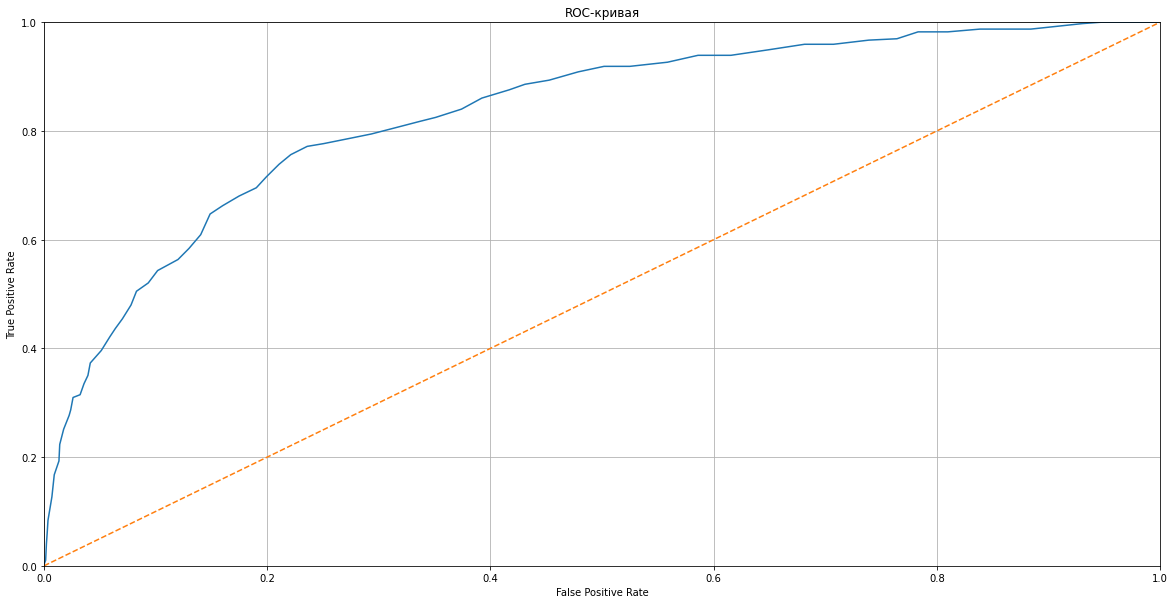

In [46]:
probabilities_valid = model.predict_proba(valid_features_normalized)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(valid_target, probabilities_one_valid)

plt.figure(figsize=(20,10))
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [48]:
statistics_threshold= pd.DataFrame(columns=['threshold', 'f1_train', 'f1_valid'])
for threshold in thresholds:
    probabilities_train = model.predict_proba(train_features_normalized)
    probabilities_one_train = probabilities_train[:, 1]
    predicted_train = probabilities_one_train > threshold

    probabilities_valid = model.predict_proba(valid_features_normalized)
    probabilities_on_valid = probabilities_valid[:, 1]
    predicted_valid = probabilities_one_valid > threshold
    
    accuracy_train = accuracy_score(target_train_downsampled,
                                    predicted_train)
    precision_train = precision_score(target_train_downsampled,
                                      predicted_train)
    recall_train = recall_score(target_train_downsampled,
                                predicted_train)
    f1_train = estimate_f1(target_train_downsampled,
                        predicted_train)
    
    accuracy_valid = accuracy_score(valid_target,
                                    predicted_valid)
    precision_valid = precision_score(valid_target,
                                      predicted_valid)
    recall_valid = recall_score(valid_target,
                                predicted_valid)
    f1_valid = estimate_f1(valid_target,
                        predicted_valid)
    
    
    #Сохраняем в DataFrame
    statistics_threshold = statistics_threshold.append(
        pd.Series([threshold, f1_train, f1_valid],
                  index=statistics_threshold.columns),
        ignore_index=True)
    

C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilka\anaconda3\envs\yandexPracticumDS\lib\s

In [49]:
statistics_threshold.sort_values(by='f1_train', ascending=False)

,threshold,f1_train,f1_valid
36,0.500000,1.000000,0.591857
40,0.444444,1.000000,0.556444
39,0.458333,1.000000,0.565693
38,0.472222,1.000000,0.578997
37,0.486111,1.000000,0.588008
...,...,...,...
4,0.958333,0.316667,0.077482
3,0.972222,0.215261,0.020000
2,0.986111,0.102477,0.005063
1,1.000000,0.000000,0.000000


<a name="4.5."></a>
## Вывод

Для устранения дизбаланса классов использовались следующие техники:
- Добавление весов, для повышения общей ценности записей об ушедших клиентов
- Увеличение количества записей о ушедших клиентах, путём их дублирования
- Уменьшение количества записей о текущих клиентах, путём их отбрасывания

На основании представленной таблицы с результатами видно, что использование взвешивания классов позволяет достичь максимальной f1-меры равной 0.58. Использование upsampling особых результатов не принесло, а вот использование downsampling позволяет повысить f1 на 2% и достичь с помощью модели случайного леса с количеством решателей равным 72 максимального значения целевой метрики. Варьирование порога для f1-метрики не привело к улучшению качества моделей
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="5."></a>
# Шаг 5. Финальное тестирование

<font size="2">([к содержанию](#0.0))</font>

In [50]:
# Объединяем обучающую и валидационную выборки
train_valid_features_normalized = np.concatenate(
    (train_features_normalized, valid_features_normalized))
target_train_valid_downsampled = np.concatenate(
    (target_train_downsampled, valid_target))

In [51]:
model = RandomForestClassifier(n_estimators=72, random_state=12345)
model.fit(train_valid_features_normalized, target_train_valid_downsampled)

RandomForestClassifier(n_estimators=72, random_state=12345)

In [52]:
test_features_normalized = scaler.transform(test_features)
predicted_test = model.predict(test_features_normalized)

In [53]:
print('Accuracy: {:.3f}'.format(accuracy_score(test_target, predicted_test)))
print('Precision: {:.3f}'.format(precision_score(test_target, predicted_test)))
print('Recall: {:.3f}'.format(recall_score(test_target, predicted_test)))
print('F1: {:.3f}'.format(estimate_f1(test_target, predicted_test)))

Accuracy: 0.853
Precision: 0.615
Recall: 0.630
F1: 0.622


<a name="6."></a>
# Шаг 6. Общие выводы

Была построена модель для прогнозирования ухода клиента из банка. Для этих целей использовались 3 типа моделей машинного обучения: 
- стационарная модель (случайное угадывание)
- логистическая регрессия
- решающее дерево
- случайный лес

В ходе предварительного анализа было обнаружено, что в задаче бинарной классификации присутствует дизбаланс классов: количество целевых клиентов (которые отказались от услуг банка) в 4 раза меньше чем тех, которые остались. Для устранения данного дизбаланса использовалось взвешивание классов, для добавления коэффициетов и повышения значимости экземпляров целевых классов, а также два других подхода: upsampling (расширение выборки) и downsampling (сужение выборки).

Наилучший результат по метрики f1 был получен на основании техники donwsampling с моделью случайного леса с количеством деревьев, равных 72. В ходе работы также производился анализ влияния изменения порога для целевого класса  с целья корректировки способа классификации результата и повышения метрики f1. Выйгрыша в метрики при изменении порога не обнаружено, поэтому пороговое значение осталось равным 0.5.

Финальное значение метрики f1=0.62, что удовлетворяет представленным требованиям к задаче.<br>

<font size="2">([к содержанию](#0.0))</font>